Categorical Columns: Index(['sex', 'age_group'], dtype='object')
Random Forest Model Accuracy: 0.89
Random Forest Model Precision: 0.93
Random Forest Model Recall: 0.84
Random Forest Model F1 Score: 0.89
Random Forest Model ROC-AUC Score: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61


Confusion Matrix:
 [[27  2]
 [ 5 27]]


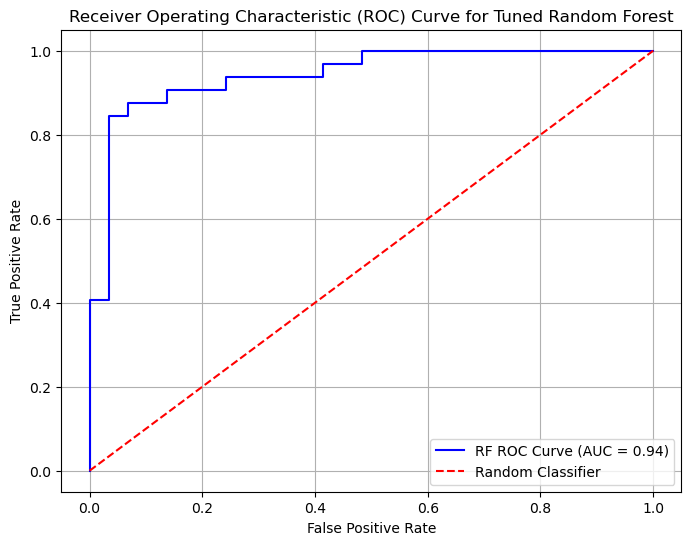


Prediction for new data with Tuned Random Forest: Heart Disease Present


In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("heart_disease_cleaned_enhanced.csv")  

# Categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print("Categorical Columns:", categorical_cols)

# Encode categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Independent (X) and Dependent Variables (y)
X = df_encoded.drop(columns=["Target"])  # Use all features except the target
y = df_encoded["Target"]  # Target variable

# Split the dataset into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Tuned Random Forest Classifier
rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=None,
    max_features='log2',
    min_samples_leaf=8,
    min_samples_split=4,
    n_estimators=161,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  

# Evaluate the Random Forest Model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Random Forest Model Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Model Precision: {precision_rf:.2f}")
print(f"Random Forest Model Recall: {recall_rf:.2f}")
print(f"Random Forest Model F1 Score: {f1_rf:.2f}")
print(f"Random Forest Model ROC-AUC Score: {roc_auc_rf:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Plot ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color="blue", label=f"RF ROC Curve (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve for Tuned Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Predict for new data
# Create a template for new data based on the feature structure of the encoded dataset
new_data_template = pd.DataFrame(columns=X.columns)
new_data_template.loc[0] = 0  #  all features to 0

# Update the template with specific values for prediction
new_data_template["age"] = 67  # Older age
new_data_template["chol"] = 300  # High cholesterol
new_data_template["oldpeak"] = 3.5  # Severe ischemic changes
new_data_template["ca"] = 3  # Increased number of major vessels with blockages
new_data_template["max_heart_rate"] = 110  # Lower maximum heart rate
new_data_template["sex_Male"] = 1  #  Male
new_data_template["thal"] = 7  # Reversible defect

# Scale the new data
new_data_scaled_rf = scaler.transform(new_data_template)

# Predict the outcome
prediction_rf = rf_model.predict(new_data_scaled_rf)
print(
    "\nPrediction for new data with Tuned Random Forest:",
    "Heart Disease Present" if prediction_rf[0] == 1 else "No Heart Disease",
)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 161}
Best Cross-Validation Accuracy: 0.84


In [6]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider
    'criterion': ['gini', 'entropy']  # Splitting criterion
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.83


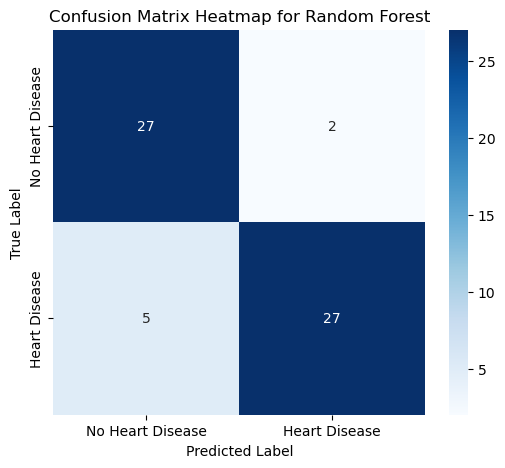

In [10]:
import seaborn as sns

# Plot Confusion Matrix as Heatmap
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Heart Disease", "Heart Disease"], yticklabels=["No Heart Disease", "Heart Disease"])
plt.title("Confusion Matrix Heatmap for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()